在上一个notebook的最后，我们注意到由ctrl为主要划分点，的确可以明显的看出分阶段的模式。
虽然根据对于符卡，道中，对话的处理策略不同导致时间上的差别，且这个变异越到后面越大。
但这些阶段的确是存在的，且我们可以给它们指派随机结构。而且这种结构是单向的，不是隐马尔科夫那种马尔科夫的，这稍微对我们参数估计有利，
对我们极其缺乏的时间（活该）也很有利。

在我们最初级的模型中，我们在策略层中加入隐含的混合策略（在最简单的模式中，我们钦定隐含策略个数，并尝试不同的数字是否带来不同的结果。），
然后策略层在各个stage，各个情景会有不同的表现方式。每个回放在每个stage上对应各个阶段划分的隐含变量。
这些隐含变量决定了各个时间格使用来自策略池在该阶段指派的参数。

策略池给四个可观测变量指派参数，pressing ctrl,shift,x,move (普通射击z的信息量太少，不加入模型中。不过如果一定要说的话，
普通射击和ctrl的信息类似，只不过过渡期中ctrl是出现峰值，而普通射击则是出现谷底。普通射击本来可以进一步用来分辨更细致的阶段，
不过我已经没有时间了，所以放弃这个打算。目前的阶段就只有ctrl可以分割的那些。)。这四个可观测变量互相，
以及自身在各时间格上在给定策略下条件独立。

联合模型，层次

S个隐含策略

各个stage中包含的情景：

* stage1:道中-秋静叶对话1-秋静叶boss战-秋静叶对话2-收尾 (无视道中boss)
* stage2:道中-转转对话1-转转boss战-转转对话2-收尾 （无视转转的道中战）
* stage3:道中1-河城荷取对话1-道中2-河城荷取对话2-河城荷取道中战-道中3-河城荷取对话3-河城荷取boss战-河城荷取对话4-收尾
* stage4:道中-射命丸文对话1-射命丸文boss战-射命丸文对话2-收尾（无视犬走椛的boss战）
* stage5:道中-早苗对话1-早苗boss战-早苗对话2-收尾（无视早苗的道中战）
* stage6:道中-神妈boss战-收尾（注意这里没有对话2）

每个情景的持续时间对应到一个对四个可观测变量的时间划分上，而各个情景的持续时间的分布是直接由策略决定的。

四个可观测变量在给定所处情景与策略下互相条件独立，且内部也独立。

对一次模拟的描述

首先我们生成S个隐含策略，这S个隐含策略对那些参数怎么控制各有独立的先验分布（因为是伪随机变量就不讲究那么多了）。
然后，我们给N个回放随机分配隐含策略，分配的概率也是一个随机向量，抽样自狄利克雷分布。
决定了分配概率向量后就按那个向量分配到N个回放使用的策略，这些随机分类变量上。
确定随机分类变量后，各个回放的各个情景开始独立根据其类型抽取其持续时间。
确定各个回放的各个清净的持续时间后，在固定的最大时间长度T上上4个可观测变量上独立的抽值，每个格上的分布决定于其对应的时间段和回放所用的策略。

这些就确定了模型中所有随机变量的一次实现值，也展示了联合分布是如何确定的与形态。接下来所要做的，就是根据数据去找到那些隐含变量和随机参数
的后验分布，这可以通过变分推断和MCMC做到。变分推断之后可以作为锦上添花试试，我们打算主要通过MCMC进行，虽然看上去并不靠谱。。。

一组可能的设定（假设）：

S = 3(隐含策略数，我们姑且把它们称为刷分策略，速攻策略与混合策略，至于到底估计出来怎么解读另说)

N = 202（对照回放数）

Sc = 33 (情景数,5+5+10+5+5+3=33。这也意味着如果每个策略给每个情景指派一个参数，则一共有99个隐含参数需要学习，当然我们可以用一些方法约束函数类型）

. St = 2 (replay自身状态数，一个策略和一个比较差的状态会有比较差的表现，如果把score加入模型这个才考虑加进去。)

T = 各个stage上的最大时间，这个时间可能是以frame算的，也可能是以1s算的，1frame还是1s对后面的模型是什么样子很有关系。

Sh-i,t 在对应的回放和时间中按着shift的个数 i是对应的回放，t是对应的时间。

Ct-i,t x-i,t mv-i,t 类似于Sh-i,t。分别表示对应回放对应时间里按着Ctrl,x键的个数。以及move指数的大小。

分布指定：

Sh,Ct,x,mv-i,t分别服从泊松，泊松，泊松，正态分布。其参数是所处情景和策略的函数。

基线模型

基线模型中没有隐含策略，所有回放看成由一种策略产生（这个只是作为对照的基线模型，真正评价模型有效性的基线模型可以就用那些经验边际分布）。
我们姑且先构建出这个模型看看建模的坑。

那么一个格一共需要5参数（4个均值一个标准差）。这5个参数是5 * Sc 共165个参数中选出来，当然总是一次选一套，共33个选择，
选择哪套由模型认为他在哪个情景决定。而这165个参数是伪随机变量，直接设它们独立地服从某种分布即可，也不好直接融入先验信息。
而33个时间长度在没有其他策略的情况下也是直接独立地从33个不同的分布抽出来的，姑且我们设它们都是正态分布。其依赖的66个参数是伪随机变量，
这里我们可以给它们的先验分布融入我们的知识，即它们先验分布的期望取成我们大概认为的值，而test_val也如此取。

这样，生成模型将首先决定66+165个伪随机变量（随机参数）的值，这是独立的。然后以66个随机参数的值为条件去产生Sc x N = 33 x 203个时间长度，
以这些时间长度，以及165个随机参数为条件。则独立的产生4 * (T1 + T2 ... + T6)个值，作为这次无条件模拟的值。这就是基线模型在无条件下的运行模拟。

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from explore_tool import load_info,press,pressing,frame_to_delta,replay_to_xy,plot_trace_2d,plot_trace_3d,plot_trace_sequence,summary,\
    look_pressing,delta_equip,load_infos,show_pressing_in_time,show_pressing_in_time2

In [2]:
%%time
infos = load_infos('replay_int16/RB')
# 结果被迫优化读取方式以免卡爆内存

Wall time: 10.3 s


In [3]:
info_list = list(infos.values())
info = infos['th10_ud000c.rpy.json.pickle']
replay = info['stages'][0]['replay']

frame_matrix = np.array([[info['stages'][i]['frame'] for i in range(6)] for info in info_list])
frame_matrix.max(axis=0)

array([11520, 13158, 15880, 17332, 20524, 24119])

In [8]:
%%time 
for info in info_list:
    delta_equip(info)

Wall time: 4.56 s


In [5]:
frame_matrix.max(axis=0)//60 + 1

array([193, 220, 265, 289, 343, 402], dtype=int32)

In [6]:
len(info_list)

202

首先我们生成标准数据，它应该是六个数组，分别为202 x 4 x 193,202 x 4 x 220,...,202 x 4 x 402的shape。
在各原始数据占满前面的格的情况下，后面的以0补齐。

In [20]:
%%time
stage_list = []
choose_keys = ['pressing_shift','pressing_ctrl','pressing_x','move']
replay_number = len(info_list)
for i,max_second in enumerate(frame_matrix.max(axis=0)//60 + 1):
    stage_arr = np.zeros((replay_number,len(choose_keys),max_second))
    for j,info in enumerate(info_list):
        df = info['stages'][i]['replay'][choose_keys]
        df = df.groupby(df.index.map(lambda t:t//60)).sum()
        mat = df.as_matrix()
        stage_arr[j,:,:mat.shape[0]] = np.transpose(mat)
    stage_list.append(stage_arr)

In [23]:
for stage_arr in stage_list:
    print(stage_arr.shape)

(202, 4, 193)
(202, 4, 220)
(202, 4, 265)
(202, 4, 289)
(202, 4, 343)
(202, 4, 402)


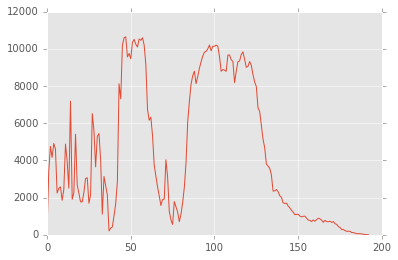

In [24]:
# 正确性验证 stage 1 的 shift pressing 情况
plt.plot(stage_list[0][:,0,:].sum(axis=0))

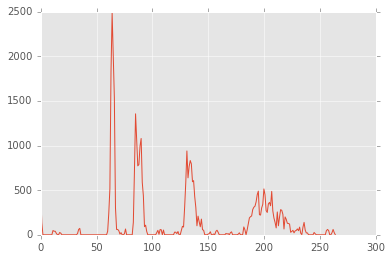

In [26]:
# # 正确性验证 stage 3 的 ctrl pressing 情况
plt.plot(stage_list[2][:,1,:].sum(axis=0))

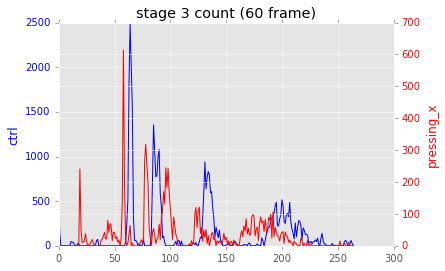

In [30]:
i = 2 # stage 3
keys = ['ctrl','pressing_x'] #  pressing x
keys_id = [1,2]
second = 60

plt.plot(stage_list[i][:,keys_id[0],:].sum(axis=0),label="{}".format(keys[0]),color='b')
plt.ylabel(keys[0],color='b')
plt.yticks(color='b')
plt.twinx()

plt.plot(stage_list[i][:,keys_id[1],:].sum(axis=0),label="{}".format(keys[0]),color='r')
plt.ylabel(keys[1],color='r')
plt.yticks(color='r')
plt.title('stage {} count ({} frame)'.format(i+1, second))
plt.show()


我们细究Sc的定义，那个收尾虽然概念上是个情景，但是它的长度是由前几个长度决定的。所以涉及时间长度的隐变量共有 
N x (Sc-6) = 202 x (4+4+9+4+4+2) = 202 x 27 = 5454个。

这由于27个时间长度随机变量被定义为独立服从27个不同的正态分布，所以这里有54个随机参数，这54个随机参数虽可以是随便的先验，
但可以融入我们的先验信息，于是通过观察，我们得到下面代码所示的与27个正态分布，54个随机参数相关的先验分布：

In [32]:
time_length_list = [
    [(,),(,),(,),(,)], # stage 1
    [(,),(,),(,),(,)], # stage 2
    [(,),(,),(,),(,),(,),(,),(,),(,),(,)], # stage 3
    [(,),(,),(,),(,)], # stage 4
    [(,),(,),(,),(,)], # stage 5
    [(,),(,)] # stage 6
]

SyntaxError: invalid syntax (<ipython-input-32-91b383fc2fd4>, line 2)